<a href="https://colab.research.google.com/github/kocurvik/edu/blob/master/PNSPV/notebooky/keras_2020/cv08-en.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 8th lab - DeepDream a adversarial attacks

In this lab we will demonstrate how to change the original image in order to visualize patterns which the network detects in its various layers. Later we will make small modifications to the input image in order to fool the network.

We will do this with a pre-trained network.

In [ ]:
import keras
import cv2
import numpy as np
from keras.applications.resnet50 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt

Since using calculating the gradient w.r.t the image is a bit more complicated in tf 2.0 eager mode we will disable the eager mode.

In [ ]:
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

In [ ]:
resnet = keras.applications.resnet.ResNet50()

102973440/102967424 [==============================] - 1s 0us/step


Let us load the images and chenge their sizes.

In [ ]:
test_imgs = []
!wget https://pixnio.com/free-images/2017/06/08/2017-06-08-13-53-59-900x576.jpg
test_imgs.append(cv2.resize(cv2.imread('2017-06-08-13-53-59-900x576.jpg'),(224,224)))
!wget https://storage.needpix.com/rsynced_images/diver-1881751_1280.jpg
test_imgs.append(cv2.resize(cv2.imread('diver-1881751_1280.jpg'),(224,224)))
!wget https://cdn.pixabay.com/photo/2017/09/22/23/24/white-stork-2777489_960_720.jpg
test_imgs.append(cv2.resize(cv2.imread('white-stork-2777489_960_720.jpg'),(224,224)))
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Croatia_police_van_%2804%29.JPG/800px-Croatia_police_van_%2804%29.JPG
test_imgs.append(cv2.resize(cv2.imread('800px-Croatia_police_van_(04).JPG'),(224,224)))


--2020-11-29 22:40:26--  https://pixnio.com/free-images/2017/06/08/2017-06-08-13-53-59-900x576.jpg
Resolving pixnio.com (pixnio.com)... 170.249.203.179
Connecting to pixnio.com (pixnio.com)|170.249.203.179|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 311968 (305K) [image/jpeg]
Saving to: ‘2017-06-08-13-53-59-900x576.jpg’

2017-06-08-13-53-59 100%[===================>] 304.66K  --.-KB/s    in 0.06s   

2020-11-29 22:40:27 (5.10 MB/s) - ‘2017-06-08-13-53-59-900x576.jpg’ saved [311968/311968]

--2020-11-29 22:40:27--  https://storage.needpix.com/rsynced_images/diver-1881751_1280.jpg
Resolving storage.needpix.com (storage.needpix.com)... 89.40.7.139
Connecting to storage.needpix.com (storage.needpix.com)|89.40.7.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 282433 (276K) [application/octet-stream]
Saving to: ‘diver-1881751_1280.jpg’

diver-1881751_1280. 100%[===================>] 275.81K   316KB/s    in 0.9s    

2020-11-29 22:40

Before using the network we have to apply the preprocessing so that it corresponds with the pre-trained neural network. **It is also necessary to make sure that the image is in the correct format which is eithe BGR as in OpenCV or RGB!**

In [ ]:
pred = resnet.predict(preprocess_input(test_imgs[0])[None, :, :, :])
print(np.argmax(pred[0]))
print(decode_predictions(pred)[0])

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
820
40960/35363 [==================================] - 0s 0us/step
[('n04310018', 'steam_locomotive', 0.9962769), ('n03393912', 'freight_car', 0.0017455405), ('n03895866', 'passenger_car', 0.0016961105), ('n03272562', 'electric_locomotive', 0.00017318252), ('n02950826', 'cannon', 6.8077155e-05)]


## DeepDream

In this section we will demonstrate the base principle of the DeepDream method which forces the network to halucinate stronger features. Here we will only see the bare algorithm, but in the original algorithm the image is also transformed at different scales and it is also shifted in between the steps. You can check out the full version in [notebook for DOD 2019 (SK)](https://github.com/kocurvik/edu/blob/master/DOD/DOD_2019_DeepDream.ipynb), or in [the original code](https://research.google.com/seedbank/seed/deepdream).

The base principle of DeepDream is simple. We will select some parts of the network (i.e. one channel of a feature map) and we will conside its values (or its second power) as a loss function. This can of course be done easily with the keras framework. Using the gradient we can then modify the image so that the loss function increases. This will allow us to obtain an inmage which activates the given part of the network the most.

In order for this to work we will have to use some backend functions. The function K.gradients will be very useful. We will also need to find the parts of network whose features interst us. We find them by listing the layers using model.layers. The representation of the input image in the framework can be obtained by using model.input


In [ ]:
import keras.backend as K

We will also need a function to invert the preprocessing in order to convert the images back and display them.

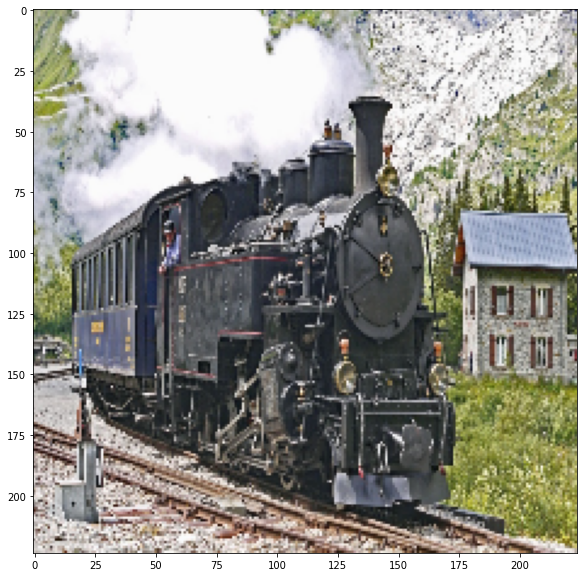

In [ ]:
def deprocess_image(img):
  mean = np.array([103.939, 116.779, 123.68])
  img += mean
  img = np.clip(img, 0, 255)
  return np.uint8(img[:,:,::-1])

img = preprocess_input(test_imgs[0])
img = deprocess_image(img)
plt.figure(figsize = (10,10))
plt.imshow(img[:,:,::-1])
plt.show()

This is the base DeepDream code. You can notice that we are iterating in a way in which the loss increases. With this implementation it is important to note that a good choice of eta is depdent on the way the loss is desing. If the loss was a sum instead of a mean we would have to choose a smaller eta.

In [ ]:
def deep_dream(input_img, model, layer_name, channel_index, eta, steps):
  model_input = model.input
  layer_dict = dict([(layer.name, layer) for layer in model.layers])
  if layer_name not in layer_dict:
    raise ValueError('Layer ' + layer_name + ' not found in model.')
  layer = layer_dict[layer_name].output
  if layer.shape[3] < channel_index:
    raise ValueError('Layer ' + layer_name + ' has only {} channels.'.format(layer.shape[3]))
  
  loss = K.mean(K.square(layer[:, :, :, channel_index]))  
  grad = K.gradients(loss, model_input)[0]
  
  fetch_loss_grad = K.function([model_input], [loss, grad])

  for i in range(steps):
    out = fetch_loss_grad([input_img])
    r_loss = out[0]    
    print("At step: {}, loss: {}".format(i, r_loss))

    r_grad = out[1]
    input_img += eta * r_grad

  return input_img

We can test our function. Let us first check out the names of the layers.

In [ ]:
print([(l.name) for l in resnet.layers[1:]])

['conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'pool1_pad', 'pool1_pool', 'conv2_block1_1_conv', 'conv2_block1_1_bn', 'conv2_block1_1_relu', 'conv2_block1_2_conv', 'conv2_block1_2_bn', 'conv2_block1_2_relu', 'conv2_block1_0_conv', 'conv2_block1_3_conv', 'conv2_block1_0_bn', 'conv2_block1_3_bn', 'conv2_block1_add', 'conv2_block1_out', 'conv2_block2_1_conv', 'conv2_block2_1_bn', 'conv2_block2_1_relu', 'conv2_block2_2_conv', 'conv2_block2_2_bn', 'conv2_block2_2_relu', 'conv2_block2_3_conv', 'conv2_block2_3_bn', 'conv2_block2_add', 'conv2_block2_out', 'conv2_block3_1_conv', 'conv2_block3_1_bn', 'conv2_block3_1_relu', 'conv2_block3_2_conv', 'conv2_block3_2_bn', 'conv2_block3_2_relu', 'conv2_block3_3_conv', 'conv2_block3_3_bn', 'conv2_block3_add', 'conv2_block3_out', 'conv3_block1_1_conv', 'conv3_block1_1_bn', 'conv3_block1_1_relu', 'conv3_block1_2_conv', 'conv3_block1_2_bn', 'conv3_block1_2_relu', 'conv3_block1_0_conv', 'conv3_block1_3_conv', 'conv3_block1_0_bn', 'conv3_block1_3_bn',

This code will run DeepDream and display the image.

At step: 0, loss: 6.264496326446533
At step: 1, loss: 6.331719398498535
At step: 2, loss: 6.399869918823242
At step: 3, loss: 6.4690022468566895
At step: 4, loss: 6.53909969329834
At step: 5, loss: 6.610109329223633
At step: 6, loss: 6.682025909423828
At step: 7, loss: 6.754871368408203
At step: 8, loss: 6.828684329986572
At step: 9, loss: 6.903491973876953
At step: 10, loss: 6.979296684265137
At step: 11, loss: 7.05605936050415
At step: 12, loss: 7.133835315704346
At step: 13, loss: 7.212646961212158
At step: 14, loss: 7.292497158050537
At step: 15, loss: 7.373322010040283
At step: 16, loss: 7.45518159866333
At step: 17, loss: 7.538158416748047
At step: 18, loss: 7.622243404388428
At step: 19, loss: 7.707429885864258
At step: 20, loss: 7.793743133544922
At step: 21, loss: 7.881155014038086
At step: 22, loss: 7.969717025756836
At step: 23, loss: 8.059440612792969
At step: 24, loss: 8.15037727355957
At step: 25, loss: 8.242568969726562
At step: 26, loss: 8.336119651794434
At step: 27, l

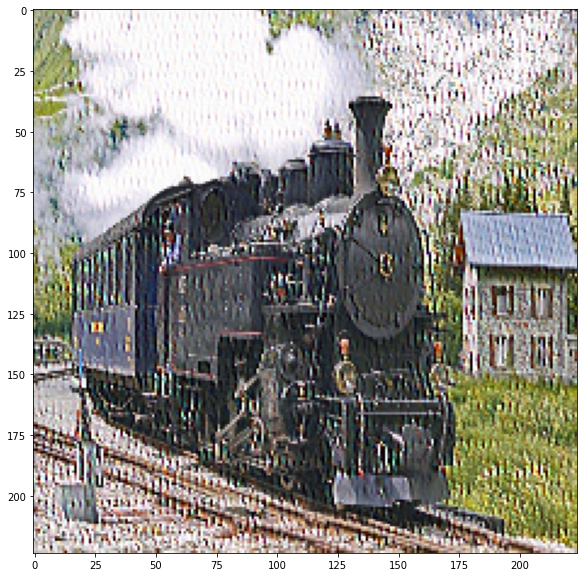

In [ ]:
in_img = preprocess_input(test_imgs[0])[np.newaxis, :, :, :]
out_img = deep_dream(in_img, resnet, 'conv2_block1_1_conv', 10, 10000, 200)
decoded_img = deprocess_image(out_img[0])
plt.figure(figsize = (10,10))
plt.imshow(decoded_img[:,:,::-1])
plt.show()

At step: 0, loss: 0.013903852552175522
At step: 1, loss: 0.016892006620764732
At step: 2, loss: 0.020706893876194954
At step: 3, loss: 0.025535225868225098
At step: 4, loss: 0.03160939738154411
At step: 5, loss: 0.03844098746776581
At step: 6, loss: 0.046816397458314896
At step: 7, loss: 0.05842567980289459
At step: 8, loss: 0.07308143377304077
At step: 9, loss: 0.09337317198514938
At step: 10, loss: 0.12091031670570374
At step: 11, loss: 0.15888088941574097
At step: 12, loss: 0.21240374445915222
At step: 13, loss: 0.2712894082069397
At step: 14, loss: 0.3319862484931946
At step: 15, loss: 0.39000245928764343
At step: 16, loss: 0.41328445076942444
At step: 17, loss: 0.38633662462234497
At step: 18, loss: 0.4209466278553009
At step: 19, loss: 0.5593417286872864
At step: 20, loss: 0.6734119057655334
At step: 21, loss: 0.6058923602104187
At step: 22, loss: 0.8442702293395996
At step: 23, loss: 0.7976517081260681
At step: 24, loss: 1.2175261974334717
At step: 25, loss: 1.079382061958313
At

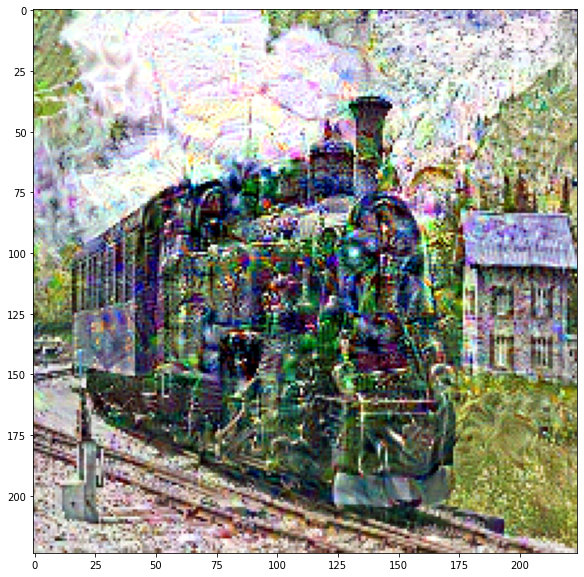

In [ ]:
in_img = preprocess_input(test_imgs[0])[np.newaxis, :, :, :]
out_img = deep_dream(in_img, resnet, 'conv5_block3_3_conv', 187, 20000, 200)
decoded_img = deprocess_image(out_img[0])
plt.figure(figsize = (10,10))
plt.imshow(decoded_img[:,:,::-1])
plt.show()

### Exercise - Adversarial attack

In order to demonstrate the shortcomings of the network we will now demonstrate how to slightly modify the input image in order to fool the network. This will be done by applying the same process as in DeepDream. This time however, we will be trying to maximize the prediction for some other class and minize the prediction for the correct class.

Implement the function adversarial dream so that it modifies the image in a way in which it predicts a different class than the original image.

In [ ]:
def adversarial_dream(input_img, model):
  return input_img

If the function is implemented correctly this code should show you the modified image and after the predict call the predicted class should be different from the original one.

Ak je funkcia správne implementovaná tento kód by mal zobraziť upravený obrázok. A po volaní predict by mala sieť vrátiť inú triedu.

0.9962769
[[('n04310018', 'steam_locomotive', 0.9962769), ('n03393912', 'freight_car', 0.0017455405), ('n03895866', 'passenger_car', 0.0016961105), ('n03272562', 'electric_locomotive', 0.00017318252), ('n02950826', 'cannon', 6.8077155e-05)]]


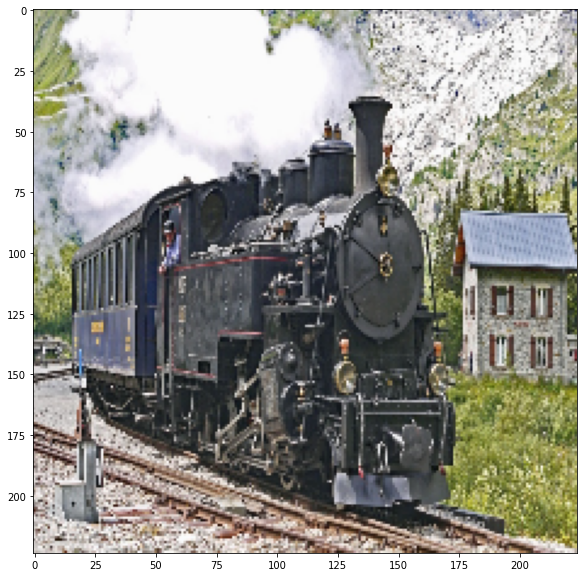

In [ ]:
in_img = preprocess_input(test_imgs[0])[np.newaxis, :, :, :]
out_img = adversarial_dream(in_img, resnet)
prediction = resnet.predict(out_img)
print(np.max(prediction[0]))
print(decode_predictions(prediction))
decoded_img = deprocess_image(out_img[0])
plt.figure(figsize = (10,10))
plt.imshow(decoded_img[:,:,::-1])
plt.show()

We can also check how the deprocessing and preprocessing affects our result. Our method may fail to work, but you can try to obtain a solution that works even when deprocessing and preprocessing again.

In [ ]:
prediction = resnet.predict(preprocess_input(decoded_img)[np.newaxis, ...])
print(np.argmax(prediction[0]))
print(decode_predictions(prediction))

820
[[('n04310018', 'steam_locomotive', 0.99611205), ('n03393912', 'freight_car', 0.0018592568), ('n03895866', 'passenger_car', 0.0017420856), ('n03272562', 'electric_locomotive', 0.00018290993), ('n02950826', 'cannon', 6.335599e-05)]]


### Exercise 2

Implement the function adversarial dream with target so that the user can also specify the class that should be predict for the image. You can see all of the IDs in [this list](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). The desired class can be very unprobable for the original image so try to accomodate for that

In [ ]:
def adversarial_dream_with_target(input_img, model, desired_class_id):
  return input_img

820
[[('n04310018', 'steam_locomotive', 0.9962769), ('n03393912', 'freight_car', 0.0017455405), ('n03895866', 'passenger_car', 0.0016961105), ('n03272562', 'electric_locomotive', 0.00017318252), ('n02950826', 'cannon', 6.8077155e-05)]]


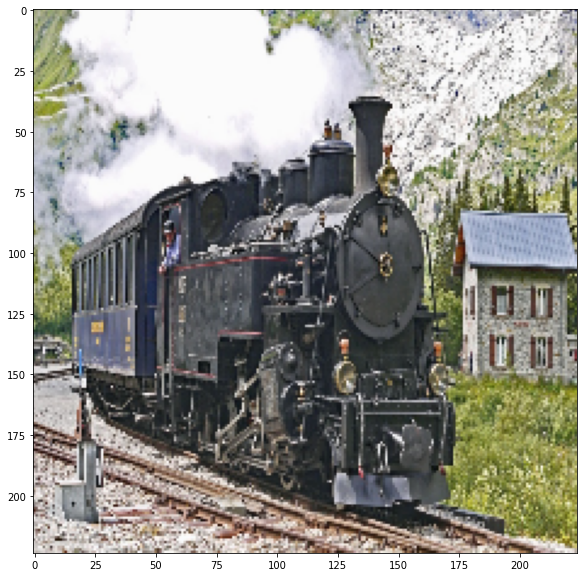

In [ ]:
in_img = preprocess_input(test_imgs[0])[np.newaxis, :, :, :]
out_img = adversarial_dream_with_target(in_img, resnet, 640)
prediction = resnet.predict(out_img)
print(np.argmax(prediction[0]))
print(decode_predictions(prediction))
decoded_img = deprocess_image(out_img[0])
plt.figure(figsize = (10,10))
plt.imshow(decoded_img[:,:,::-1])
plt.show()

We can now check whether deprocessing and preprocessing hurts our attack.

In [ ]:
prediction = resnet.predict(preprocess_input(decoded_img)[np.newaxis, ...])
print(np.argmax(prediction[0]))
print(decode_predictions(prediction))

820
[[('n04310018', 'steam_locomotive', 0.99611205), ('n03393912', 'freight_car', 0.0018592568), ('n03895866', 'passenger_car', 0.0017420856), ('n03272562', 'electric_locomotive', 0.00018290993), ('n02950826', 'cannon', 6.335599e-05)]]


We can also check the image differences.

0.0
-1.0
float32


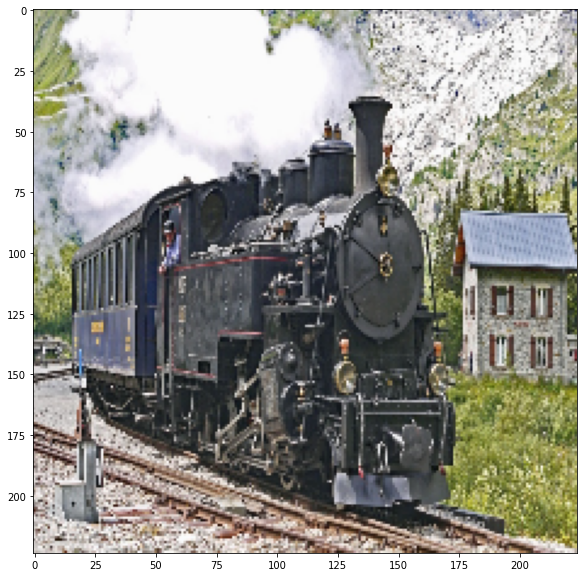

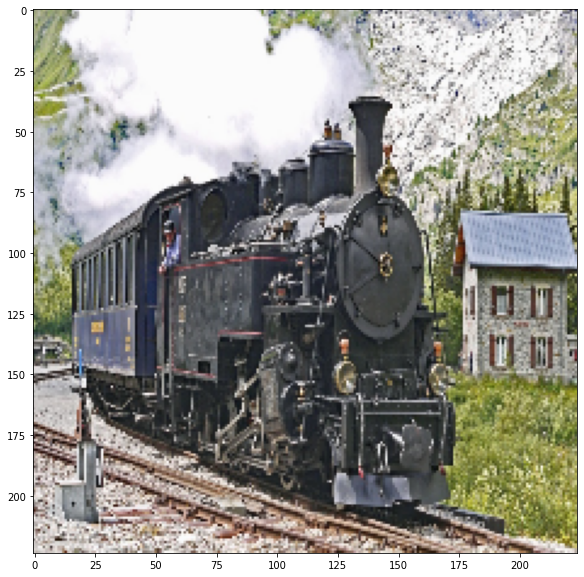

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


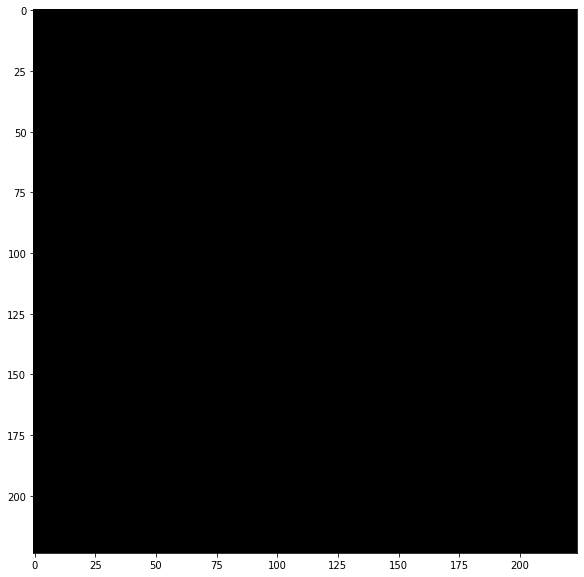

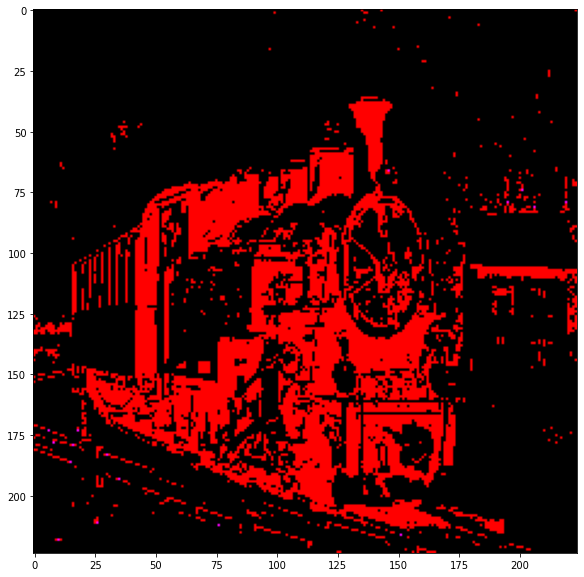

In [ ]:
diff_img = decoded_img.astype(np.float32) - test_imgs[0].astype(np.float32)


print(np.max(diff_img))
print(np.min(diff_img))

diff_img /= np.max(np.abs(diff_img))

print(diff_img.dtype)

plt.figure(figsize = (10,10))
plt.imshow(decoded_img[:,:,::-1])
plt.show()
plt.figure(figsize = (10,10))
plt.imshow(test_imgs[0][:,:,::-1])
plt.show()
plt.figure(figsize = (10,10))
plt.imshow(diff_img[:,:,::-1])
plt.show()
plt.figure(figsize = (10,10))
plt.imshow(-diff_img[:,:,::-1])
plt.show()

### Exercise 3 - FGSM

So far we have modified the image by adding the gradients to the pixel values. In other words for some loss function $L$ we modified every pixel value $I_{i, j}$ in the following way:

$$ I_{i, j}^{n + 1} = I_{i, j}^{n} + \eta \frac{\partial L}{\partial I_{i, j}}$$

The FGSM method is based on changing this rule to:

$$ I_{i, j}^{n + 1} = I_{i, j}^{n} + sgn \left(\frac{\partial L}{\partial I_{i, j}} \right)$$,

where $sgn$ is the sign function. We will therefore always add 0, 1 or -1 to the pixel values. This can change the image significantly faster. Another benefit is that if we have the original image in the uint8 data and the preprocessing does not perform any multiplication of the values we will obtain a valid image after each step and the deprocessing and subsequent processing will not change the image values.

Try to implement FGSM. You can overwrite some of the earlier code examples.
